## Import Semua Packages/Library yang Digunakan

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import os
import shutil
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

## Data Preparation

### Data Loading

In [2]:
dataset_path = 'Dataset/Original'

train_datagen = ImageDataGenerator(rescale=1./255)  

generator = train_datagen.flow_from_directory(
    directory=dataset_path,  
    target_size=(256, 256),   
    batch_size=32,
    class_mode='categorical', 
    shuffle=False             
)


print(f"Total classes: {len(generator.class_indices)}")  
print(f"Total images: {generator.samples}")  
print(f"Class labels: {generator.class_indices}")  


Found 2159 images belonging to 5 classes.
Total classes: 5
Total images: 2159
Class labels: {'Anthracnose': 0, 'BacterialSpot': 1, 'Curl': 2, 'Healthy': 3, 'RingSpot': 4}


### Data Preprocessing

#### Split Dataset

In [4]:
def split_dataset(original_dir, output_dir, split_ratio=(0.7, 0.15, 0.15), seed=42):
    random.seed(seed)
    classes = os.listdir(original_dir)
    for cls in classes:
        cls_path = os.path.join(original_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_end = int(split_ratio[0] * total)
        val_end = train_end + int(split_ratio[1] * total)

        for i, img in enumerate(images):
            if i < train_end:
                split = 'train'
            elif i < val_end:
                split = 'validation'
            else:
                split = 'test'

            dest_dir = os.path.join(output_dir, split, cls)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(os.path.join(cls_path, img), os.path.join(dest_dir, img))

split_dataset('Dataset/Original', 'Dataset/after_split', split_ratio=(0.7, 0.15, 0.15))

## Modelling

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Path dataset
base_dir = 'Dataset/after_split'

# Augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
    fill_mode='nearest'
)

# Untuk validasi dan test cukup rescale
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# --- OPTIONAL: Class weight handling (jika dataset tidak seimbang)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Membangun model CNN yang diperbaiki
model = Sequential([
    Input(shape=(256, 256, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax') 

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('saved_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks=callbacks
)

Found 1509 images belonging to 5 classes.
Found 321 images belonging to 5 classes.
Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2192 - loss: 1.6266 - val_accuracy: 0.2710 - val_loss: 1.5643 - learning_rate: 1.0000e-04
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 948ms/step - accuracy: 0.2415 - loss: 1.5902 - val_accuracy: 0.2710 - val_loss: 1.5664 - learning_rate: 1.0000e-04
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 949ms/step - accuracy: 0.2304 - loss: 1.6082 - val_accuracy: 0.2461 - val_loss: 1.5639 - learning_rate: 1.0000e-04
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 945ms/step - accuracy: 0.2521 - loss: 1.5810 - val_accuracy: 0.2710 - val_loss: 1.5637 - learning_rate: 1.0000e-04
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 963ms/step - accuracy: 0.2441 - loss: 1.5876 - val_accuracy: 0.2710 - val_loss: 1.5644 - learning_rate: 1.0000e-04
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 949ms/step - accuracy: 0.2462 - loss: 1.5809 - val_accuracy: 0.2710 - val_loss: 1.5633 

## Evaluasi dan Visualisasi

In [11]:
base_dir = 'Dataset/after_split'
model_path = 'finetuned_model.keras'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model = load_model(model_path)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 329 images belonging to 5 classes.
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.8276 - loss: 0.4318
Test Loss: 0.5660269856452942
Test Accuracy: 0.7750759720802307


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Prediksi: Healthy


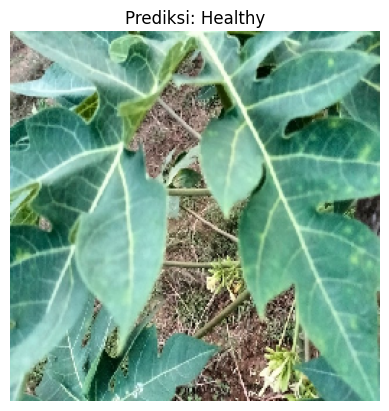

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Load model
model = tf.keras.models.load_model('finetuned_model.keras')

img_path = 'Healthy(223).jpg'  

# Preprocessing gambar
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  
img_array = np.expand_dims(img_array, axis=0)  

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]

class_labels = ['Anthracnose', 'BacterialSpot', 'Curl', 'Healthy', 'RingSpot']
predicted_label = class_labels[pred_class]

print(f"Prediksi: {predicted_label}")
plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()


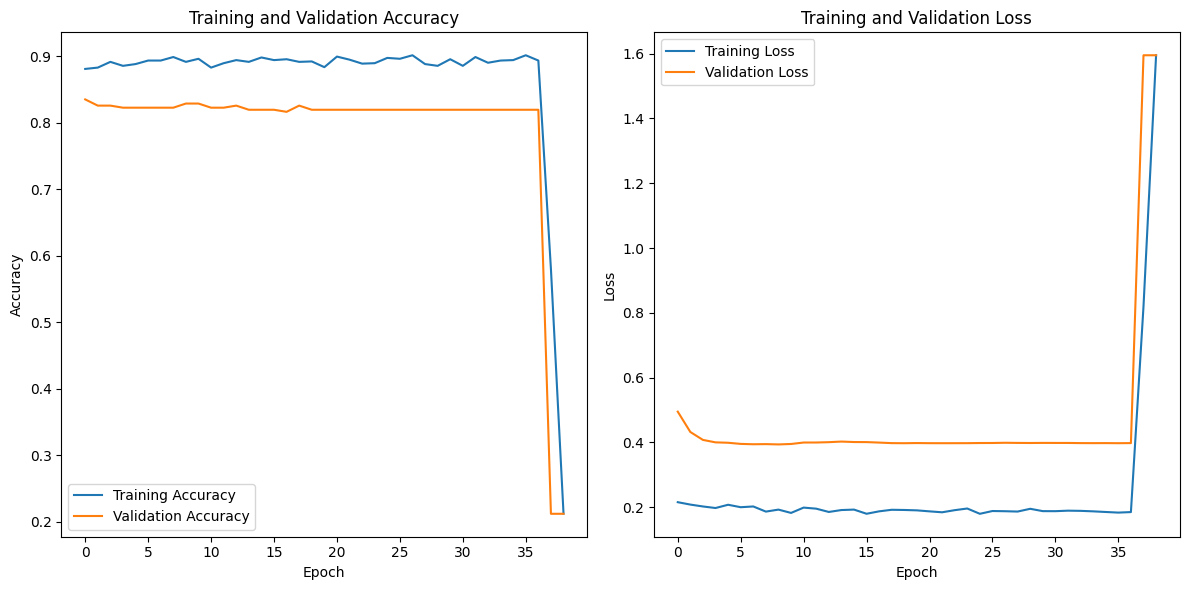

In [17]:
# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step
AP for class 'Anthracnose': 0.9651
AP for class 'BacterialSpot': 0.7402
AP for class 'Curl': 0.8282
AP for class 'Healthy': 0.9415
AP for class 'RingSpot': 0.9308

Mean Average Precision (mAP): 0.8811

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.91      0.93      0.92        54
BacterialSpot       0.53      0.89      0.66        70
         Curl       0.87      0.51      0.64        89
      Healthy       0.82      0.91      0.86        35
     RingSpot       0.95      0.77      0.85        81

     accuracy                           0.76       329
    macro avg       0.81      0.80      0.79       329
 weighted avg       0.82      0.76      0.76       329



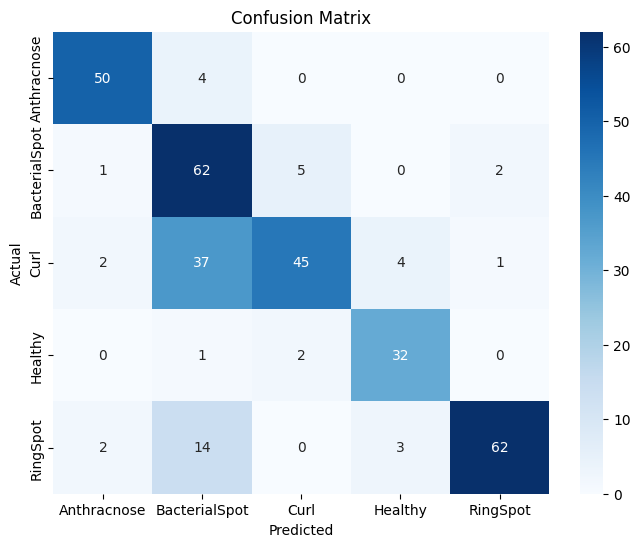

In [22]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load model
model = tf.keras.models.load_model('saved_model.keras')

# Ulangi test_generator untuk dapatkan semua data
test_generator.reset()
y_pred_prob = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Konversi y_true ke one-hot
num_classes = y_pred_prob.shape[1]
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Daftar nama kelas
class_labels = list(test_generator.class_indices.keys())

# Hitung AP per kelas dan mAP
aps = []
for i, class_name in enumerate(class_labels):
    ap = average_precision_score(y_true_onehot[:, i], y_pred_prob[:, i])
    aps.append(ap)
    print(f"AP for class '{class_name}': {ap:.4f}")
map_score = np.mean(aps)
print(f"\nMean Average Precision (mAP): {map_score:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
